## Newtonian Orbits
The following code aims to model the orbit of two bodies $M_1$ and $M_2$ using purely Newtonian techniques. We implemented the RK4 solver to calculate the positions over time.

In [2]:
# imports
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
# gravitational constant
G = 6.67430e-11

In [4]:
# initialize Body class 
class Body():
    def __init__(self, pos_vec, v_vec, mass):
        self.pos = pos_vec
        self.v = v_vec
        self.mass = mass
        self.state = np.concatenate((self.pos, self.v))
    
    def return_state(self):
        return self.state
   

In [5]:
class Simulation():
    def __init__(self, bodies):
        self.bodies = bodies
        self.N_bodies = 2 # expect 2 bodies for our simulation
        self.Ndim = 4 # composed of (x,y) components for position, velocity
        
        self.b1 = bodies[0]
        self.b2 = bodies[1]
        self.state_vec = np.vstack((self.b1.return_state(), self.b2.return_state()))
        self.mass_vec = np.array([self.b1.mass, self.b2.mass])

    def set_ODEs(self, solver):
        self.solver = solver

    def rk4(self, dt):
        k1 = dt * self.solver(self.state_vec, self.mass_vec)
        k2 = dt * self.solver(self.state_vec + 0.5 * k1, self.mass_vec)
        k3 = dt * self.solver(self.state_vec + 0.5 * k2, self.mass_vec)
        k4 = dt * self.solver(self.state_vec + k3, self.mass_vec)

        new_state = self.state_vec + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        return new_state

    def run(self, dt, steps):
        self.b1_history = np.zeros((steps, 4))
        self.b2_history = np.zeros((steps, 4))

        # set initial state
        self.b1_history[0] = self.b1.return_state()
        self.b2_history[0] = self.b2.return_state()

        for i in range(1, steps):
            # calculate new state with rk4
            new_state = self.rk4(dt)

            # append new state to history
            b1_new = new_state[0]
            b2_new = new_state[1]
            self.b1_history[i] = b1_new
            self.b2_history[i] = b2_new

            # set state_vec attribute as the new state
            self.state_vec = new_state

            # repeat

In [6]:
# solver routine
def solve_orbit(state_vec, masses):
    # masses
    m1 = masses[0]
    m2 = masses[1]

    # positions
    b1_pos = state_vec[0][0:2]
    b2_pos = state_vec[1][0:2]

    # velocities
    b1_v = state_vec[0][2:]
    b2_v = state_vec[1][2:]

    # separations
    dx = b1_pos[0] - b2_pos[0] # points from b2 to b1
    dy = b1_pos[1] - b2_pos[1]

    # r separation distance
    r = np.sqrt(dx**2 + dy**2)
    r3 = r**3

    # calculate accelerations
    ax_1 = ((-G * m2) / r3) * dx
    ay_1 = ((-G * m2) / r3) * dy

    ax_2 = ((-G * m1) / r3) * (-dx)
    ay_2 = ((-G * m1) / r3) * (-dy)

    # return the derivatives
    b1_a = np.array([ax_1, ay_1])
    b1_derivs = np.concatenate((b1_v, b1_a)) # velocity and acceleration

    b2_a = np.array([ax_2, ay_2])
    b2_derivs = np.concatenate((b2_v, b2_a)) # velocity and acceleration

    # stack
    return np.vstack((b1_derivs, b2_derivs))

In [26]:
# Example Usage 
# define two black hole masses
m1 = 40 * 1.9885e30  
m2 = 30 * 1.9885e30 

# define separation
r = 1e10  

# position components
x1 = -m2 / (m1 + m2) * r
x2 =  m1 / (m1 + m2) * r
y1 = y2 = 0

# orbital velocity
v_orb = np.sqrt(G * (m1 + m2) / r)

# velocity components
vx1 = 0
vy1 =  m2 / (m1 + m2) * v_orb
vx2 = 0
vy2 = -m1 / (m1 + m2) * v_orb

# create Bodies
bh1 = Body(np.array([x1, y1]), np.array([vx1, vy1]), m1)
bh2 = Body(np.array([x2, y2]), np.array([vx2, vy2]), m2)

# create Simulation
bh_sim = Simulation([bh1, bh2])

# set solver
bh_sim.set_ODEs(solve_orbit)


In [27]:
# run simulation
bh_sim.run(50, int(115810 / 50))

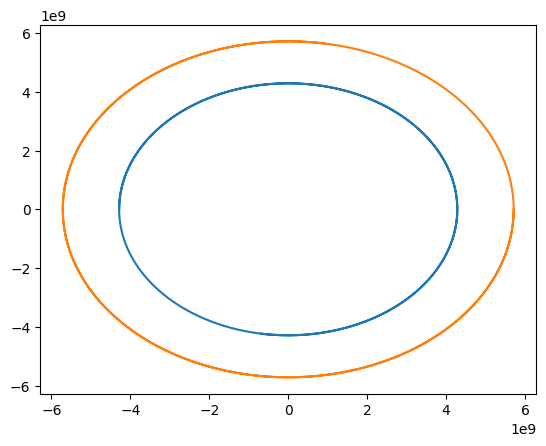

In [30]:
# plot orbits
# compute center of mass for each step
xCM = np.zeros(2316)
yCM = np.zeros(2316)

for i in range(0, len(bh_sim.b1_history[:, 0])):
    x1 = bh_sim.b1_history[:, 0][i]
    x2 = bh_sim.b2_history[:, 0][i]
    xcm = ((m1*x1) + (m2*x2)) / (m1 + m2)

    y1 = bh_sim.b1_history[:, 1][i]
    y2 = bh_sim.b2_history[:, 1][i]
    ycm = ((m1*y1) + (m2*y2)) / (m1 + m2)

    xCM[i] = xcm
    yCM[i] = ycm

x1_rel = bh_sim.b1_history[:, 0] - xCM
y1_rel = bh_sim.b1_history[:, 1] - yCM


x2_rel = bh_sim.b2_history[:, 0] - xCM
y2_rel = bh_sim.b2_history[:, 1] - yCM

plt.plot(x1_rel, y1_rel)
plt.plot(x2_rel, y2_rel)

plt.show()